In [1]:
import geopandas as gp
from shapely import wkt
from shapely.geometry import Point, Polygon
from shapely.ops import unary_union
import pandas as pd
import numpy as np
from pprint import pprint
import os
import glob
import openpyxl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import plotly.express as px #if using plotly
import folium
import warnings
import random

In [2]:
pd.set_option('display.max_columns', None)  # display all columns
pd.options.display.float_format = '{:20,.2f}'.format  # suppress scientific notation

## Research Questions

### 1) Is there a significant difference in the proportion of minorities within a given flaring buffer zone versus outside the buffer? 

#### Ultimate goal is a comparison of three different buffers (400, 1000, 2000) following Czolowski et al, 2017 (they did 100; 400; 800; 1,000; 1,600; and 2,000 m)

#### Two comparisons: In_buffer versus all of California, and a geographically narrower version: in_buffer versus only the subset of the population in BGs that intersect a flare or are adjacent to a BG that intersects a flare. 

Null: Proportion of BG in a buffer is independent of minority status.  
Alt:  Proportion of BG in a buffer is related to minority status.
  
Test stat: Difference in weighted minority proportions.

Weighted minority proportion = sumproduct(minority_prop * intersect_prop) / sum(intersect_prop)
minority_prop is the proportion of minorities in a block group
intersect_prop is the proportion of BG area residing in the buffer zone

Permutation testing: Permute the intersect_prop variable, holding the fraction of minorities in each BG constant.
 
Process   
a) Calculate the actual minority proportions of the aggregrate in-buffer and out-buffer areas
Using 2km buffer for starters (Czolowski, 2017)  
b) Scramble the intersect_prop variable, holding the minority_prop variable constant.   
c) Calculate number of simulated proportions that match or exceed the actual proportion. Calculate p-value.  


## Load data, set project CRS

In [3]:
ca_state = gp.read_file("data/CA_State_TIGER2016.shp")  # CA state
ca_counties = gp.read_file("data/CA_Counties_TIGER2016.shp")  # CA counties
ca_bg = gp.read_file("data/ca_bg_clean.shp")  # CA block groups, cleaned

In [4]:
# just CA flares
ca_flares = gp.read_file("data/ca_flares_clean.shp")
print(f'Flares found: {len(ca_flares)}')

# CA block groups merged with EJscreen data
ca_bg_joined = gp.read_file("data/ca_bg_joined_clean.shp", dtype={'bg_id': 'int', 'index':'int'})

# update col name for correct area b/c it gets saved as a truncated version when saved as a shapefile out of the 
# main data cleaning notebook
ca_bg_joined.rename(columns={'shape_ar_1':'shape_area_new'}, inplace=True)  # old:new.
print(f'BGs found: {len(ca_bg_joined)}')

Flares found: 117
BGs found: 25607


In [5]:
# set common crs for project
# epsg3310: https://epsg.io/3310-1739
# units: meters
meters_crs = 3310  # Projected crs. this should be good for this overlay() calculation and all of project. 

ca_state = ca_state.to_crs(meters_crs)
ca_counties = ca_counties.to_crs(meters_crs)
ca_bg = ca_bg.to_crs(meters_crs)

#### Discuss w RMI: dropping the three aquatic buffers

In [6]:
# There are five BGs that seem to just be aquatic buffers around the actual county land.
# Dropping them for now 
# Explore if needed: ca_bg_joined.explore()

ids_to_drop = [60839900000, 61119901000, 60379902000, 60379903000, 60599901000]

# Drop the rows with those IDs
ca_bg_joined = ca_bg_joined[~ca_bg_joined['bg_id'].isin(ids_to_drop)]

In [7]:
ca_counties.rename(columns={'NAMELSAD':'CNTY_NAME'}, inplace=True)  # old:new. Match col names for merging

# subset to only cols needed
ca_bg_joined_sub = ca_bg_joined[['bg_id', 'CNTY_NAME', 'ACSTOTPOP', 'MINORPOP',
                           'D_PM25_2', 'shape_area_new', 'geometry']].copy()

ca_bg_joined_sub.rename(columns={'geometry':'bg_geom'}, inplace=True)  # old:new. Match col names for merging

counties_sub = ca_counties[['CNTY_NAME', 'geometry']].copy()

counties_sub.rename(columns={'geometry':'cnty_geom'}, inplace=True)  # old:new. Match col names for merging

# add county names to social dataframe
ca_bg_joined_sub = pd.merge(ca_bg_joined_sub, counties_sub, 
                             on='CNTY_NAME', how='left')

#### Store for later use if necessary: subsetting to only intersected counties

In [8]:
# # subset full social df down to just the rows that are in the intersected counties
# county_names = intersect_df['CNTY_NAME'].unique()
# social_counties = ca_bg_joined_sub[ca_bg_joined_sub['CNTY_NAME'].isin(county_names)]

#### Subset full social data down to just intersected BGs and BGs adjacent ("touching") to the intersected BGs. 

In [9]:
# buffer_size=2000
# ca_flares, intersect_df = create_buffer_intersection(ca_flares, ca_bg_joined_sub, buffer_size)

In [10]:
# intersect_df = intersect_df.set_geometry('intersect_geom')
# ca_bg_joined_sub = ca_bg_joined_sub.set_geometry('bg_geom')

# intersect_mask = intersect_df['bg_id'].unique()

In [11]:
# intersect_bgs = ca_bg_joined_sub[ca_bg_joined_sub['bg_id'].isin(intersect_mask)]

In [12]:
# intersect_bgs[intersect_bgs['bg_id']==60375754011]

### Use the intersected BGs to subset the full df to only the BGs adjacent to the intersected BGs. 

In [13]:
# inter_adj_df = gp.sjoin(ca_bg_joined_sub, intersect_bgs, how = "inner", predicate = 'intersects')

In [14]:

# # clean up df after sjoin brought a bunch of extra cols in
# to_drop = []

# for col in inter_adj_df.columns:
    
#     # Check if the column name ends with '_left'
#     if col.endswith('_left'):
#         new_col = col[:-5]
#         inter_adj_df = inter_adj_df.rename(columns={col:new_col})

#     # drop the '_right' cols bc they're duplicates
#     elif col.endswith('_right'):
#         to_drop.append(col)

# inter_adj_df = inter_adj_df.drop(to_drop, axis=1)

# # drop duplicates brought in by the sjoin()
# inter_adj_df = inter_adj_df.drop_duplicates(subset=['bg_id'])


In [15]:
# inter_adj_df[inter_adj_df['bg_id']==60375754011]

In [16]:
# # ensure that the intersections, not the counties, are set as the geometry for calculations.
# intersect_df = intersect_df.set_geometry('intersect_geom')  # set to the buffers rather than the points

# # Create new 'area' column for the areas of the intersections
# intersect_df['intersect_area'] = intersect_df.area

# # Calculate the proportion of each block group within the buffer zone
# intersect_df['intersect_prop'] = intersect_df['intersect_area'] / intersect_df['shape_area_new']



# # merge the intersections data back into the (subsetted) social df. This creates a df of all BGs — those
# # that contain intersections and those that do not — in the counties that have an intersection. 

# # I'm creating a subset of California, in effect, to combat against the extremely skewed dataset when I 
# # compare the in/out buffer proportions across all of Cali. 
# bgs_intersections = pd.merge(inter_adj_df, 
#                              intersect_df[['bg_id','intersect_geom','intersect_area', 'intersect_prop']], 
#                              on=['bg_id'], 
#                              how='left').fillna({'intersect_area': 0, 'intersect_prop': 0})

In [17]:
# # Apply the proportion to each demographic variable to find counts by variable
# demo_vars = ['ACSTOTPOP', 'MINORPOP']
# for var in demo_vars:
#     bgs_intersections[var + '_intersect_count'] = bgs_intersections[var] * bgs_intersections['intersect_prop']

# # find overall proportions for each demo var by dividing var count by respective total population    
# for var in demo_vars:
#     bgs_intersections[var + '_bg_totprop'] = np.where(bgs_intersections['ACSTOTPOP'] != 0, 
#                                                       bgs_intersections[var] / bgs_intersections['ACSTOTPOP'], 0)

# bgs_intersections['outintersect_prop'] = 1-bgs_intersections['intersect_prop']

# # Calculate the in_buffer and out_buffer proportions for the sample
# in_buffer = np.sum(bgs_intersections['MINORPOP_bg_totprop'] * bgs_intersections['intersect_prop']) / np.sum(bgs_intersections['intersect_prop'])
# out_buffer = np.sum(bgs_intersections['MINORPOP_bg_totprop'] * bgs_intersections['outintersect_prop']) / np.sum(bgs_intersections['outintersect_prop'])



In [18]:
# # why so many duplicates?

# # sample bg
# bgs_intersections[bgs_intersections['bg_id']==60375754011]

# Functions

In [45]:
def write_files(df, analysis_type):
    """
    Write final df to tsv for permutation in R. 
    Analyis type = either "ca" for all of Cali BGs, or "adjacent" for the intersected and intersected-adjacent BGs
    """
    
    # drop the geometries before writing to files if they're present; they're not needed for permutation
    columns_to_drop = ["bg_geom", "intersect_geom", "cnty_geom"]
    columns_present = set(columns_to_drop).intersection(set(df.columns))

    if len(columns_present) > 0:
        df = df.drop(columns=list(columns_present))    
    
    filename = f"data/{analysis_type}_df_{buffer_size}m_forpermutation.tsv"
    df.to_csv(filename, sep="\t", index=False)
    return

In [20]:
def create_buffer_intersection(flares_df, social_df, buffer_size):
    """
    Creates a new Geodf containing the intersection between census BGs
    and buffers of {buffer size} around flare sites.
    
    Parameters
    ----------
    flares_df : A Geodf containing point geometries representing flare sites.
    social_df : A Geodf containing polygon geometries representing social data from EPA EJScreen
    buffer_size : int
        The size of the buffer around each flare site, in meters.
    
    Returns
    -------
    tuple of GeoDataFrames
        A tuple containing two GeoDataFrames:
        1. The original flares_df with a new buffer column added.
        2. A GeoDataFrame containing the intersection between social_df and the 
        union of all buffer geometries in flares_df.
    """
    
    social_df = social_df.set_geometry('bg_geom')
    
    #flares_df = set_geometry_buffer(flares_df, buffer_size)
    buffer_col = f"buffer_{buffer_size}m"
    flares_df[buffer_col] = flares_df['geometry'].buffer(distance=buffer_size)

    flares_df = flares_df.set_geometry(buffer_col)
    
    temp = flares_df.unary_union
    all_buffers = gp.GeoDataFrame({'geometry': [temp]}, crs=flares_df.crs)  # convert back to geodf for processing
    
    intersect_temp = gp.overlay(social_df, all_buffers, how='intersection')  # could look at keep_geom=False
    
    intersect_temp.rename(columns={'geometry':'intersect_geom'}, inplace=True)  # old:new. Match col names for merging
    
    return flares_df, intersect_temp

## Comparison set: All BGs in California

In [21]:
def calculate_stats_ca(intersect_portions, social_df, buffer_size, analysis_type):
    """
    Calculates statistics related to the intersection between buffer zones and census block groups.
    BGs used for analysis are all California BGs. 

    Parameters:
    -----------
    intersect_portions : pandas.df
        df containing information on intersections between buffer zones and census block groups.
    social_df : pandas.df
        df containing social variables for each census block group.
    buffer_size : int
        Size of the buffer zone in meters.
    """
    
    intersect_portions_temp = intersect_portions

    # ensure that the intersections, not the counties, are set as the geometry for calculations.
    intersect_portions_temp = intersect_portions_temp.set_geometry('intersect_geom')  # set to the buffers rather than the points

    # Create new 'area' column for the areas of the intersections
    intersect_portions_temp['intersect_area'] = intersect_portions_temp.area

    # Calculate the proportion of each block group within the buffer zone
    intersect_portions_temp['intersect_prop'] = intersect_portions_temp['intersect_area'] / intersect_portions_temp['shape_area_new']

    bgs_intersections = pd.merge(social_df, 
                                 intersect_portions_temp[['bg_id','intersect_geom','intersect_area', 'intersect_prop']], 
                                 on=['bg_id'], 
                                 how='left').fillna({'intersect_area': 0, 'intersect_prop': 0})

    # Apply the proportion to each demographic variable to find counts by variable
    demo_vars = ['ACSTOTPOP', 'MINORPOP']
    for var in demo_vars:
        bgs_intersections[var + '_intersect_count'] = bgs_intersections[var] * bgs_intersections['intersect_prop']

    # find overall proportions for each demo var by dividing var count by respective total population    
    for var in demo_vars:
        bgs_intersections[var + '_bg_totprop'] = np.where(bgs_intersections['ACSTOTPOP'] != 0, 
                                                          bgs_intersections[var] / bgs_intersections['ACSTOTPOP'], 0)

    bgs_intersections['outintersect_prop'] = 1-bgs_intersections['intersect_prop']

    # Calculate the in_buffer and out_buffer proportions for the sample
    in_buffer = (np.sum(bgs_intersections['MINORPOP_bg_totprop'] * bgs_intersections['intersect_prop']) /
                 np.sum(bgs_intersections['intersect_prop']))
    out_buffer = (np.sum(bgs_intersections['MINORPOP_bg_totprop'] * bgs_intersections['outintersect_prop']) /
                  np.sum(bgs_intersections['outintersect_prop']))

    # old print statements; not used now but may be useful in future
#     print(f" buffer: *{buffer_size}m*")
#     print(f" BGs in buffer: {len(intersect_portions_temp)} out of total: {len(bgs_intersections)}")
#     print(f" People in buffer: {round(sum(bgs_intersections['ACSTOTPOP_intersect_count'])):,} out of total: {sum(bgs_intersections['ACSTOTPOP']):,}")
#     print()
#     print(f" in_buffer prop: {in_buffer}")
#     print(f" out_buffer prop: {out_buffer}")
#     print()
    
    # Create a dictionary to hold the output for this buffer size    
    output_dict = {
        'analysis_type': analysis_type,
        'buffer_size (m)': buffer_size,
        'BGs_50%ormore_overlap': (bgs_intersections.groupby('bg_id')['intersect_prop'].
                                  apply(lambda x: (x >= .5).sum()).sum()),
        'BGs_full_overlap': (bgs_intersections.groupby('bg_id')['intersect_prop'].
                             apply(lambda x: (x == 1).sum()).sum()),
        'BGs_inbuffer': len(intersect_portions_temp),
        'BGs_total': len(bgs_intersections['bg_id'].unique()),
        'pop_inbuffer': round(bgs_intersections.groupby('bg_id')['ACSTOTPOP_intersect_count'].sum().sum()),
        'pop_total': sum(bgs_intersections.groupby('bg_id')['ACSTOTPOP'].sum()),
        'inbuffer_prop': in_buffer,
        'outbuffer_prop': out_buffer,
        'prop_diff': in_buffer-out_buffer
    }
    
    # Return the output as a DataFrame
    return bgs_intersections, pd.DataFrame(output_dict, index=[0])

In [22]:
# Comparison set: all BGs in California

buffer_sizes = [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800, 3000, 4000, 5000, 7500, 10000]

# initialize empty df
df_view_ca = pd.DataFrame()

for buffer_size in buffer_sizes:
    ca_flares, intersect_portions = create_buffer_intersection(ca_flares, ca_bg_joined_sub, buffer_size)
    df_ca_forpermutation, buffer_output = calculate_stats_ca(intersect_portions, ca_bg_joined_sub, buffer_size, "ca")

    df_view_ca = df_view_ca.append(buffer_output, ignore_index=True) 

In [23]:
df_view_ca

,analysis_type,buffer_size (m),BGs_50%ormore_overlap,BGs_full_overlap,BGs_inbuffer,BGs_total,pop_inbuffer,pop_total,inbuffer_prop,outbuffer_prop,prop_diff
0,ca,200,0,0,42,25602,548,39346023,0.39,0.60,-0.21
1,ca,400,0,0,52,25602,2602,39346023,0.44,0.60,-0.16
2,ca,600,2,0,63,25602,6231,39346023,0.48,0.60,-0.13
3,ca,800,4,0,75,25602,12244,39346023,0.54,0.60,-0.06
4,ca,1000,10,0,90,25602,22852,39346023,0.59,0.60,-0.01
5,ca,1200,17,1,120,25602,38606,39346023,0.63,0.60,0.03
6,ca,1400,33,5,145,25602,59812,39346023,0.66,0.60,0.06
7,ca,1600,47,14,176,25602,86993,39346023,0.70,0.60,0.09
8,ca,1800,72,29,204,25602,122005,39346023,0.72,0.60,0.12
9,ca,2000,99,41,238,25602,162231,39346023,0.74,0.60,0.13


In [24]:
# write_files(df_view_ca, "ca")

## Comparison set: only intersected and intersected-adjacent BGs

In [48]:
def calculate_stats_adjacent(intersect_portions, social_df, buffer_size, analysis_type):
    """
    Calculates statistics related to the intersection between buffer zones and census block groups.
    BGs used for analysis are those that contain an intersection with a buffer and those BGs adjacent to the
    intersected BGs.

    Parameters:
    -----------
    intersect_portions : pandas.df
        df containing information on intersections between buffer zones and census block groups.
    social_df : pandas.df
        df containing social variables for each census block group.
    buffer_size : int
        Size of the buffer zone in meters.
    """
    
    social_df = social_df.set_geometry('bg_geom')
    
    # Mask for filtering social_df down to just intersected BGs
    intersect_portions_temp = intersect_portions
    intersect_portions_temp = intersect_portions_temp.set_geometry('intersect_geom')
    intersect_mask = intersect_portions_temp['bg_id'].unique()
    
    # Create filtered df of all intersected BGs plus adjacent BGs to those intersected
    intersect_bgs = social_df[social_df['bg_id'].isin(intersect_mask)]
    intersect_bgs = intersect_bgs.set_geometry('bg_geom')  # set to the buffers rather than the points

    # the intersection of the intersect_bgs df and the original social_df gives us a 
    # df of all intersected and adjacent-to-the-intersected BGs.
    inter_adj_df = gp.sjoin(social_df, intersect_bgs, how = "inner", predicate = 'intersects')
    
    # clean up extra cols after the sjoin() and drop duplicates
    inter_adj_df = inter_adj_df.loc[:, ~inter_adj_df.columns.str.endswith('_right')]
    inter_adj_df.columns = inter_adj_df.columns.str.replace('_left', '')
    inter_adj_df = inter_adj_df.drop_duplicates(subset=['bg_id'])

    # Conduct area and proportions calculations
    # ensure that the intersections, not the counties, are set as the geometry for calculations.
    intersect_portions_temp = intersect_portions_temp.set_geometry('intersect_geom') 
    intersect_portions_temp['intersect_area'] = intersect_portions_temp.area
    # Calculate the proportion of each block group within the buffer zone
    intersect_portions_temp['intersect_prop'] = intersect_portions_temp['intersect_area'] / intersect_portions_temp['shape_area_new']

    # Merge the area & proportions vars back into the (subsetted) social df. This creates a df of all BGs — those
    # that contain intersections and those that do not — in the bgs that have an intersection plus BGs adjacent
    # to the intersected BGs. 
    # I'm creating a subset of California, in effect, to combat against the extremely skewed dataset when I 
    # compare the in/out buffer proportions across all of Cali. 
    bgs_intersections = pd.merge(inter_adj_df, 
                                 intersect_portions_temp[['bg_id','intersect_geom',
                                                          'intersect_area', 'intersect_prop']], 
                                 on=['bg_id'], 
                                 how='left').fillna({'intersect_area': 0, 'intersect_prop': 0})

    # Apply the proportion to each demographic variable to find counts by variable
    demo_vars = ['ACSTOTPOP', 'MINORPOP']
    for var in demo_vars:
        bgs_intersections[var + '_intersect_count'] = bgs_intersections[var] * bgs_intersections['intersect_prop']

    # find overall proportions for each demo var by dividing var count by respective total population    
    for var in demo_vars:
        bgs_intersections[var + '_bg_totprop'] = np.where(bgs_intersections['ACSTOTPOP'] != 0, 
                                                          bgs_intersections[var] / bgs_intersections['ACSTOTPOP'], 0)

    bgs_intersections['outintersect_prop'] = 1-bgs_intersections['intersect_prop']

#     Calculate the weighted in_buffer and out_buffer proportions Minority status for the int & adj df
    in_buffer = (np.sum(bgs_intersections['MINORPOP_bg_totprop'] * bgs_intersections['intersect_prop']) /
                 np.sum(bgs_intersections['intersect_prop']))
    out_buffer = (np.sum(bgs_intersections['MINORPOP_bg_totprop'] * bgs_intersections['outintersect_prop']) /
                  np.sum(bgs_intersections['outintersect_prop']))
    
    # TEST
#     in_buffer = np.mean(bgs_intersections.query("intersect_prop>0")['MINORPOP_bg_totprop'])
#     out_buffer = np.mean(bgs_intersections.query("intersect_prop==0")['MINORPOP_bg_totprop'])


    # Create a dictionary to hold the output for this buffer size
    output_dict = {
        'analysis_type': analysis_type,
        'buffer_size (m)': buffer_size,
        'BGs_50%ormore_overlap': (bgs_intersections.groupby('bg_id')['intersect_prop'].
                                  apply(lambda x: (x >= .5).sum()).sum()),
        'BGs_full_overlap': (bgs_intersections.groupby('bg_id')['intersect_prop'].
                             apply(lambda x: (x == 1).sum()).sum()),
        'BGs_inbuffer': len(intersect_mask),
        'BGs_total': len(bgs_intersections['bg_id'].unique()),
        'pop_inbuffer': round(bgs_intersections.groupby('bg_id')['ACSTOTPOP_intersect_count'].sum().sum()),
        'pop_total': sum(bgs_intersections.groupby('bg_id')['ACSTOTPOP'].sum()),
        'inbuffer_prop': in_buffer,
        'outbuffer_prop': out_buffer,
        'prop_diff': in_buffer-out_buffer
    }
    
    # Return the output_dict as a DataFrame for viewing
    # Return the final df bgs_intersections for further permutation testing in R 
    return bgs_intersections, pd.DataFrame(output_dict, index=[0])


In [49]:
# Comparison set: only intersected and intersect-adjacent BGs

#buffer_sizes = [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800, 3000, 4000, 5000, 7500, 10000]
buffer_sizes = [200]

# initialize empty df
df_view_adjacent = pd.DataFrame()

for buffer_size in buffer_sizes:
    
    ca_flares, intersect_portions = create_buffer_intersection(ca_flares, ca_bg_joined_sub, buffer_size)
    df_adjacent_forpermutation, buffer_output = calculate_stats_adjacent(intersect_portions, ca_bg_joined_sub, buffer_size, "adjacent")

    df_view_adjacent = df_view_adjacent.append(buffer_output, ignore_index=True) 

In [50]:
df_view_adjacent

,analysis_type,buffer_size (m),BGs_50%ormore_overlap,BGs_full_overlap,BGs_inbuffer,BGs_total,pop_inbuffer,pop_total,inbuffer_prop,outbuffer_prop,prop_diff
0,adjacent,200,0,0,42,376,548,613188,0.39,0.65,-0.27


In [51]:
write_files(df_adjacent_forpermutation, "adjacent")

### Prop table

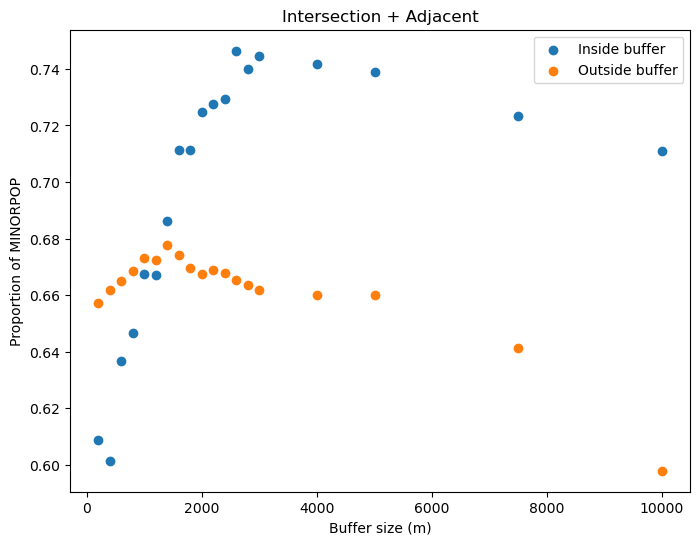

In [38]:
# scatterplot of buffer props

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(df_view_adjacent['buffer_size (m)'], df_view_adjacent['inbuffer_prop'], label='Inside buffer')
ax.scatter(df_view_adjacent['buffer_size (m)'], df_view_adjacent['outbuffer_prop'], label='Outside buffer')

# Set xticks to the buffer sizes
# xticks = [100, 400, 800, 1000, 1600, 2000]
# ax.set_xticks(xticks)

# Set xticklabels to the buffer sizes
#xticklabels = [f"{b:,}" for b in xticks]
#ax.set_xticklabels(xticklabels)
ax.set_xlabel('Buffer size (m)')
ax.set_ylabel('Proportion of MINORPOP')
ax.legend()
plt.title("Intersection + Adjacent")
plt.show()


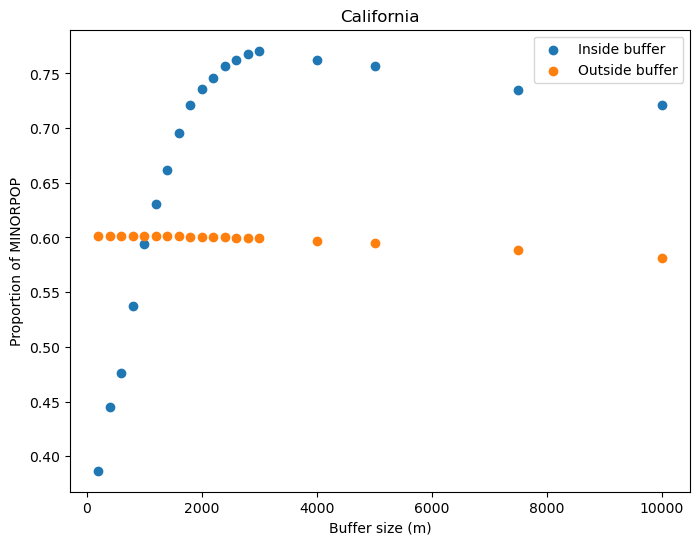

In [34]:
# CA scatterplot of buffer props

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(df_view_ca['buffer_size (m)'], df_view_ca['inbuffer_prop'], label='Inside buffer')
ax.scatter(df_view_ca['buffer_size (m)'], df_view_ca['outbuffer_prop'], label='Outside buffer')

# Set xticks to the buffer sizes
# xticks = [100, 400, 800, 1000, 1600, 2000]
# ax.set_xticks(xticks)

# Set xticklabels to the buffer sizes
#xticklabels = [f"{b:,}" for b in xticks]
#ax.set_xticklabels(xticklabels)
ax.set_xlabel('Buffer size (m)')
ax.set_ylabel('Proportion of MINORPOP')
ax.legend()
plt.title("California")
plt.show()

### Counts

In [ ]:
# scatterplot of buffer counts
# visualizing just in-buffer counts for readability. 

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(df_view_adjacent['buffer_size (m)'], df_view_adjacent['pop_inbuffer'], label='Inside buffer')
#ax.scatter(df_view_adjacent['buffer_size (m)'], df_view_adjacent['pop_outbuffer'], label='Outside buffer')

# Define the formatter function
def thousand_fmt(x, pos):
    return f"{x:,.0f}"
# Set the formatter function for the y-axis
ax.yaxis.set_major_formatter(mtick.FuncFormatter(thousand_fmt))

# Set xticks to the buffer sizes
xticks = [100, 400, 800, 1000, 1600, 2000, 5000, 7500, 10000]
ax.set_xticks(xticks)

# Set xticklabels to the buffer sizes
xticklabels = [f"{b:,}" for b in xticks]
ax.set_xticklabels(xticklabels)
ax.set_xlabel('Buffer size (m)')
ax.set_ylabel('Counts of MINORPOP')
ax.legend()
plt.show()

## Visualization with Folium

In [ ]:
# # Convert the GeoDataFrame to the same CRS as the folium map (if necessary)

# # Create a folium map with a center location
# m = folium.Map(location=[38.377158,-121.645792], zoom_start=6, tiles=None,overlay=False)  #start w lat/long roughly in center of CA
# base_map = folium.FeatureGroup(name='Base map', overlay=True, control=False)
# folium.TileLayer(tiles='OpenStreetMap').add_to(base_map)
# base_map.add_to(m)

In [ ]:
# # Feature Group: All CA block groups

# def style_function2(feature):
#     return {
#         'fillColor': 'grey',
#         'color': 'grey',
#         'fillOpacity': 0.01
#     }

# all_ca_bg = folium.FeatureGroup(name='All CA BG', overlay=True)
# folium.GeoJson(
#     data=ca_bg_joined_sub['bg_geom'],
#     style_function=style_function2
# ).add_to(all_ca_bg)
# all_ca_bg.add_to(m)

In [ ]:
# # Feature Group: Full BG geom for intersected Block Groups

# def style_function4(feature):
#     return {
#         'fillColor': 'red',
#         'color': 'red',
#         'fillOpacity': 0.05
#     }

# all_bg = folium.FeatureGroup(name='Intersect BG', overlay=True)
# folium.GeoJson(
#     data=intersect_bgs["bg_geom"],
#     style_function=style_function4
# ).add_to(all_bg)
# all_bg.add_to(m)

In [ ]:
# # Feature Group: Intersect portion of intersected Block Groups

# def style_function3(feature):
#     return {
#         'fillColor': 'blue',
#         'color': 'blue',
#         'fillOpacity': 0.05
#     }

# inter_all_bg = folium.FeatureGroup(name='Intersect BG', overlay=True)
# folium.GeoJson(
#     data=intersect_df["intersect_geom"],
#     style_function=style_function3
# ).add_to(inter_all_bg)
# inter_all_bg.add_to(m)

In [ ]:
# # Feature Group: Intersected and Adjacent Block Groups

# def style_function5(feature):
#     return {
#         'fillColor': 'green',
#         'color': 'green',
#         'fillOpacity': 0.05
#     }

# inter_adj_fg = folium.FeatureGroup(name='Intersect & Adjacent BG', overlay=True)
# folium.GeoJson(
#     data=inter_adj_df["bg_geom"],
#     style_function=style_function5
# ).add_to(inter_adj_fg)
# inter_adj_fg.add_to(m)

In [ ]:
# # Feature Group: Buffers

# def style_function1(feature):
#     return {
#         'fillColor': 'red',
#         'color': 'red',
#         'fillOpacity': 0.1
#     }

# all_flares_buffers = folium.FeatureGroup(name='Flare Buffers', overlay=True)
# folium.GeoJson(
#     data=ca_flares["buffer_2000m"],
#     style_function=style_function1
# ).add_to(all_flares_buffers)
# all_flares_buffers.add_to(m)




In [ ]:
# # Feature Group: Counties

# # def style_function1(feature):
# #     return {
# #         'fillColor': 'red',
# #         'color': 'red',
# #         'fillOpacity': 0.2
# #     }

# # all_flares_buffers = folium.FeatureGroup(name='Flare Buffers', overlay=True)
# # folium.GeoJson(
# #     data=intersect_df["cnty_geom"],
# #     style_function=style_function1
# # ).add_to(all_flares_buffers)
# # all_flares_buffers.add_to(m)

In [ ]:
# # Add hover functionality
# test = test.to_crs("EPSG:3857")
# test = test.set_geometry('bg_geom')
# test_json = test.__geo_interface__

In [ ]:

# style_function = lambda x: {'fillColor': '#ffffff', 
#                             'color':'#000000', 
#                             'fillOpacity': 0.1, 
#                             'weight': 0.1}
# highlight_function = lambda x: {'fillColor': '#999999', 
#                                 'color':'#999999', 
#                                 'fillOpacity': 0.50, 
#                                 'weight': 0.1}
# NIL = folium.features.GeoJson(
#     data = intersect_df,
#     style_function=style_function, 
#     control=False,
#     highlight_function=highlight_function, 
#     tooltip=folium.features.GeoJsonTooltip(
#         fields=['ID','CNTY_NAME'],# 'D_PM25_2', 'ACSTOTPOP', 'MINORPOP','shape_area_new', 'intersect_prop', 'intersect_area', 'MINORPOP_bg_totprop'],
#         style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
#     )
# )

In [ ]:
# # add hover functionality as child to map, add layering, display map
# m.add_child(NIL)
# m.keep_in_front(NIL)
# folium.LayerControl().add_to(m)
# m

In [ ]:
# # Flares
# all_flares_points = folium.FeatureGroup(name='flare points', overlay=True)
# folium.GeoJson(data=ca_flares["geometry"]).add_to(all_flares_points)
# all_flares_points.add_to(m)

In [ ]:
#m